# 项目背景

在做大型促销活动前一天的上午，业务方得到了一些数据，想要基于现有的数据做回归预测。但限制条件是，1个小时之内必须给出结果，在线等待，越快越好。

基于上述场景和需求，本次分析的交付需求如下：
- 这是一次回归任务，木笔哦是预测数值。
- 由于时间紧任务重，因此无法通过非常深入的观察、探索性分析、深入的算法选择核参数调优等方式得到最优结果，因此必须在有限时间内得到尽量好的结果。
- 本次工作不注重中间过程，只要求最后结果。

**数据源特征**：
- 


In [2]:
# 导入库
import pandas as pd
import numpy as np

from sklearn.linear_model import BayesianRidge, ElasticNet# 批量导入要实现的回归算法
from sklearn.svm import SVR  # SVM中的回归算法
from xgboost import XGBRegressor
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor  # 集成算法

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
mean_squared_error, r2_score  # 批量导入指标算法

import matplotlib.pyplot as plt  # 导入图形展示库

In [13]:
#读取数据 数据预处理
raw_data = np.loadtxt('regression.txt')
X_raw,y = raw_data[:, :-1], raw_data[:, -1]
model_ss = StandardScaler() #标准化
X = model_ss.fit_transform(x_raw) 

In [15]:
#拆分数据集
num = int(0.7 * X.shape[0])
X_train,X_test = X[:num, :], X[num:, :]
y_train,y_test = y[:num],y[num:]

In [20]:
n_folds = 5
model_names = ['BayesianRidge', 'XGBR', 'ElasticNet', 'SVR', 'GBR']
model_br = BayesianRidge()                                                  #建立贝叶斯岭回归模型对象
model_xgbr = XGBRegressor(random_state=0)                                   #建立XGBR对象
model_etc = ElasticNet(random_state=0)                                      #建立弹性网络回归模型对象
model_svr = SVR(gamma='scale')                                              #建立支持向量机回归模型对象
model_gbr = GradientBoostingRegressor(random_state=0)                       #建立梯度增强回归模型对象
model_list = [model_br, model_xgbr, model_etc, model_svr, model_gbr]        #不同回归模型对象的集合

pre_y_list = [model.fit(X_train, y_train).predict(X_test) for model in model_list] #各个回归模型预测的y值列表

[19:42:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\teamo\Anaconda3\lib\site-packages\xgboost\core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


In [33]:
#交叉检验评估不同模型的训练效果
n_samples, n_features = X.shape                                                                             #总样本量，总特征数
model_metrics_functions = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]     #回归评估指标对象之集
model_metrics_list = [[m(y_test, pre_y_list[i]) for m in model_metrics_functions] for i in range(len(pre_y_list))] #回归评估指标列表
regression_score = pd.DataFrame(model_metrics_list, index=model_names, columns=['explained_variance', 'mae', 'mse', 'r2']) #建立回归指标的数据框
print('all samples: %d \t features: %d' % (n_samples, n_features), '\n', '-'*60)
print('\n', 'regression metrics:', '\n', '-'*60)
print(regression_score)

all samples: 506 	 features: 13 
 ------------------------------------------------------------

 regression metrics: 
 ------------------------------------------------------------
               explained_variance       mae         mse        r2
BayesianRidge           -0.687361  7.659193  121.319137 -0.828575
XGBR                     0.266921  4.646828   50.015036  0.246152
ElasticNet               0.071882  6.291600   70.266387 -0.059086
SVR                     -0.000399  8.283070  104.300648 -0.572065
GBR                      0.230913  4.922672   53.285483  0.196858


**从上述结果发现，集成类算法XGBoost和GBR的效果最好。贝叶斯和SVR在默认参数下是比较差的；ElasticNet效果还可以，但要弱于两个集成算法。**

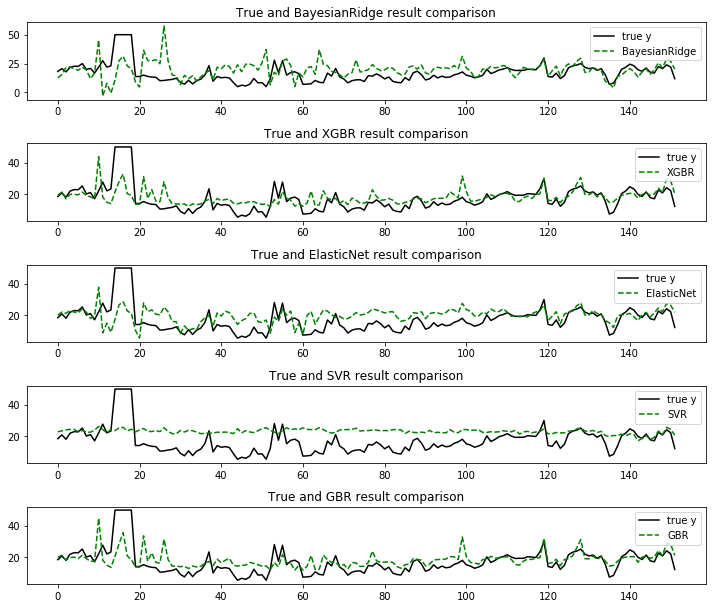

In [45]:
#模型效果指标评估
#使用matplotlib将原始数据y和其他5个回归模型预测到的y值通过趋势图进行对比。
plt.figure(figsize=(10,10)) #创建画布
for i, pre_y in enumerate(pre_y_list):
    plt.subplot(len(pre_y_list)+1, 1, i+1)
    plt.plot(np.arange(len(y_test)),y_test, color='k', label='true y')       #画出原始值的曲线
    plt.plot(np.arange(len(pre_y)), pre_y, 'g--', label=model_names[i]) #画出每条预测结果线
    plt.title('True and {} result comparison'.format(model_names[i]))         #标题
    plt.legend(loc='upper right')                                            #图例位置
    plt.tight_layout()                                                       #自动调整子图间隔

In [48]:
# 模型应用
print('regression prediction','\n','-'*40)
new_point_set = [[1.05393, 0., 8.14, 0., 0.538, 5.935, 29.3, 4.4986, 4., 307., 21., 386.85, 6.58],
                 [0.7842, 0., 8.14, 0., 0.538, 5.99, 81.7, 4.2579, 4., 307., 21., 386.75, 14.67],
                 [0.80271, 0., 8.14, 0., 0.538, 5.456, 36.6, 3.7965, 4., 307., 21., 288.99, 11.69],
                 [0.7258, 0., 8.14, 0., 0.538, 5.727, 69.5, 3.7965, 4., 307., 21., 390.95,
                  11.28]]  # 要预测的新数据集
for i, new_point in enumerate(new_point_set):  # 循环读出每个要预测的数据点
    x_matrix = np.array(new_point).reshape(1, -1)
    x_scaled = model_ss.transform(x_matrix)
    new_pre_y = model_xgbr.predict(x_scaled)  # 使用GBR进行预测
    print('predict for new point %d is:  %.2f' % (i + 1, new_pre_y))  # 打印输出每个数据点的预测信息

regression prediction 
 ----------------------------------------
predict for new point 1 is:  22.28
predict for new point 2 is:  17.25
predict for new point 3 is:  18.82
predict for new point 4 is:  18.12
